In [1]:
%matplotlib inline

import numpy as np
import torch
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as func

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


# Dataset

In [2]:
from torchvision.datasets import MNIST
from torchvision.datasets import FashionMNIST
import torchvision.transforms as transforms

num_workers = 0
batch_size = 64
img_resize = 64   # resize to 64x64 imgs

transform = transforms.Compose([transforms.Resize(img_resize), transforms.ToTensor()])

mnist_train_data = MNIST(root='data', train=True, download=True, transform=transform)
mnist_train_loader = torch.utils.data.DataLoader(mnist_train_data, num_workers=num_workers, batch_size=batch_size)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw



# GAN Model

In [3]:


class Discriminator(nn.Module):
    def __init__(self, in_channels, n_features, out_channels):
        super(Discriminator, self).__init__()

        self.conv1 = nn.Conv2d(in_channels=in_channels, out_channels=n_features, kernel_size=4, stride=2, padding=1)    #32x32
        self.batchnorm1 = nn.BatchNorm2d(num_features=n_features)
        self.conv2 = nn.Conv2d(in_channels=n_features, out_channels=n_features*2, kernel_size=4, stride=2, padding=1) #16x16
        self.batchnorm2 = nn.BatchNorm2d(num_features=n_features*2)
        self.conv3 = nn.Conv2d(in_channels=n_features*2, out_channels=n_features*4, kernel_size=4, stride=2, padding=1) #8x8
        self.batchnorm3 = nn.BatchNorm2d(num_features=n_features*4)
        self.conv4 = nn.Conv2d(in_channels=n_features*4, out_channels=n_features*8, kernel_size=4, stride=2, padding=1) #4x4
        self.batchnorm4 = nn.BatchNorm2d(num_features=n_features*8)

        self.conv5 = nn.Conv2d(in_channels=n_features*8, out_channels=out_channels, kernel_size=4, stride=1, padding=0) #1x1
        
    def forward(self, x):

        # conv2d -> batchnorm2d -> leakyrelu -> conv2d...
        x = self.conv1(x)
        x = self.batchnorm1(x)
        x = func.leaky_relu(x, 0.2)
        x = self.conv2(x)
        x = self.batchnorm2(x)
        x = func.leaky_relu(x, 0.2)
        x = self.conv3(x)
        x = self.batchnorm3(x)
        x = func.leaky_relu(x, 0.2)
        x = self.conv4(x)
        x = self.batchnorm4(x)
        x = func.leaky_relu(x, 0.2)

        out = self.conv5(x)
        
        return out

In [4]:
class Generator(nn.Module):
    def __init__(self, in_channels, n_features, out_channels):
        super(Generator, self).__init__()
        # project and reshape z
        self.convT1 = nn.ConvTranspose2d(in_channels=in_channels, out_channels=n_features*16, kernel_size=4, stride=1, padding=0) # 4x4
        self.batchnorm1 = nn.BatchNorm2d(num_features=n_features*16)
        
        self.convT2 = nn.ConvTranspose2d(in_channels=n_features*16, out_channels=n_features*8, kernel_size=4, stride=2, padding=1) # 8x8
        self.batchnorm2 = nn.BatchNorm2d(num_features=n_features*8)
        self.convT3 = nn.ConvTranspose2d(in_channels=n_features*8, out_channels=n_features*4, kernel_size=4, stride=2, padding=1)  # 16x16
        self.batchnorm3 = nn.BatchNorm2d(num_features=n_features*4)
        self.convT4 = nn.ConvTranspose2d(in_channels=n_features*4, out_channels=n_features*2, kernel_size=4, stride=2, padding=1)  # 32x32
        self.batchnorm4 = nn.BatchNorm2d(num_features=n_features*2)

        self.convT5 = nn.ConvTranspose2d(in_channels=n_features*2, out_channels=out_channels, kernel_size=4, stride=2, padding=1) # 64x64
        


    def forward(self, x):
        # conv2d -> batchnorm2d -> relu -> conv2d...
        x = self.convT1(x)
        x = self.batchnorm1(x)
        x = func.relu(x)
        x = self.convT2(x)
        x = self.batchnorm2(x)
        x = func.relu(x)
        x = self.convT3(x)
        x = self.batchnorm3(x)
        x = func.relu(x)
        x = self.convT4(x)
        x = self.batchnorm4(x)
        x = func.relu(x)
     
        # output
        out = func.tanh(self.convT5(x))
        
        return out

# Training

In [5]:
# Discriminator hyperparams
d_in_channels = 1        # gray-scale     
d_out_channels = 1      # real or fake
d_n_features = 64

# Generator hyperparams
z_size = 100             # Size of latent vector
g_out_channels = 1       # gray_scale
g_n_features = 64

In [6]:
D = Discriminator(in_channels=d_in_channels, n_features=d_n_features, out_channels=d_out_channels).to(device)
G = Generator(in_channels=z_size, n_features=g_n_features, out_channels=g_out_channels).to(device)

print(D)
print(G)

Discriminator(
  (conv1): Conv2d(1, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (batchnorm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (batchnorm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (batchnorm3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv4): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (batchnorm4): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv5): Conv2d(512, 1, kernel_size=(4, 4), stride=(1, 1))
)
Generator(
  (convT1): ConvTranspose2d(100, 1024, kernel_size=(4, 4), stride=(1, 1))
  (batchnorm1): BatchNorm2d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (convT2): ConvTranspose2d(1024, 512, k

In [7]:
import torch.optim as optim

lr = 0.0002

# Create optimizers for the discriminator and generator
d_optimizer = optim.Adam(D.parameters(), lr)
g_optimizer = optim.Adam(G.parameters(), lr)

criterion = nn.BCEWithLogitsLoss()

In [8]:
import pickle as pkl

num_epochs = 15
samples = []
losses = []

print_every = 400

sample_size = 32
fixed_z = torch.randn((sample_size, z_size, 1, 1)).to(device)

D.train()
G.train()
for epoch in range(num_epochs):
    for batch, (real_images, _) in enumerate(mnist_train_loader):
        real_images = real_images.to(device)  # batch_size x 64 x 64
        batch_size = real_images.size(0)
        
        # rescale input images from [0,1) to [-1, 1)
        real_images = real_images*2 - 1  
        
        # TRAIN THE DISCRIMINATOR
        d_optimizer.zero_grad()
        
        # 1. Train with real images
        real_labels = torch.ones(batch_size).to(device)
        # One-sided label smoothing
        real_labels = real_labels * 0.9     # real labels = 0.9
        D_out_real = D(real_images)
        d_real_loss = criterion(D_out_real.squeeze(), real_labels)
        
        # 2. Train with fake images
        # Generate fake images
        with torch.no_grad():
            z = torch.randn((batch_size, z_size, 1, 1)).to(device)
            fake_images = G(z)
        fake_labels = torch.zeros(batch_size).to(device) # fake labels = 0
        # loss on fake images
        D_out_fake = D(fake_images)
        d_fake_loss = criterion(D_out_fake.squeeze(), fake_labels)
        
        # 3. Add up loss
        d_loss = d_real_loss + d_fake_loss

        # backprop
        d_loss.backward()
        d_optimizer.step()
        
        # TRAIN THE GENERATOR
        g_optimizer.zero_grad()
        
        # Generate fake images
        z = torch.randn((batch_size, z_size, 1, 1)).to(device)
        fake_images = G(z)
        
        D_out_fake = D(fake_images)
        g_loss = criterion(D_out_fake.squeeze(), real_labels)   # flip labels
        
        # backprop
        g_loss.backward()
        g_optimizer.step()


        if batch % print_every == 0:
            print('Epoch [{:5d}/{:5d}] | d_loss: {:.4f} | g_loss: {:.4f}'.format(
                epoch+1, num_epochs, d_loss.item(), g_loss.item()))

    losses.append((d_loss.item(), g_loss.item()))

    # generate and save samples
    G.eval()
    samples_z = G(fixed_z)
    samples.append(samples_z)
    G.train()

# Save training generator samples
with open('DCGAN_train_samples.pkl', 'wb') as f:
    pkl.dump(samples, f)

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1795: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


Epoch [    1/   15] | d_loss: 1.4367 | g_loss: 2.0818
Epoch [    1/   15] | d_loss: 0.3322 | g_loss: 7.0554
Epoch [    1/   15] | d_loss: 0.3255 | g_loss: 8.3262
Epoch [    2/   15] | d_loss: 0.3276 | g_loss: 8.7962
Epoch [    2/   15] | d_loss: 0.3256 | g_loss: 9.5420
Epoch [    2/   15] | d_loss: 0.3252 | g_loss: 9.5413
Epoch [    3/   15] | d_loss: 0.3264 | g_loss: 9.9401
Epoch [    3/   15] | d_loss: 0.4331 | g_loss: 4.5530
Epoch [    3/   15] | d_loss: 0.3258 | g_loss: 7.7643
Epoch [    4/   15] | d_loss: 0.4554 | g_loss: 4.9146
Epoch [    4/   15] | d_loss: 0.3491 | g_loss: 5.8720
Epoch [    4/   15] | d_loss: 0.4184 | g_loss: 4.3271
Epoch [    5/   15] | d_loss: 0.5900 | g_loss: 3.5344
Epoch [    5/   15] | d_loss: 0.7924 | g_loss: 4.2773
Epoch [    5/   15] | d_loss: 0.7442 | g_loss: 2.2913
Epoch [    6/   15] | d_loss: 0.6892 | g_loss: 3.6048
Epoch [    6/   15] | d_loss: 0.6270 | g_loss: 4.0988
Epoch [    6/   15] | d_loss: 0.4656 | g_loss: 1.7485
Epoch [    7/   15] | d_loss

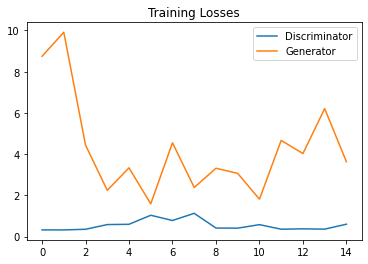

In [9]:
fig, ax = plt.subplots()
losses = np.array(losses)
plt.plot(losses.T[0], label='Discriminator')
plt.plot(losses.T[1], label='Generator')
plt.title("Training Losses")
plt.legend()

# Sample

## Training sample

In [145]:
def view_samples(epoch, samples):
    fig, axes = plt.subplots(figsize=(7,7), nrows=5, ncols=5, sharey=True, sharex=True)
    for ax, img in zip(axes.flatten(), samples[epoch]):
        img = img.detach().cpu()
        ax.xaxis.set_visible(False)
        ax.yaxis.set_visible(False)
        im = ax.imshow(img.reshape((64,64)), cmap='Greys_r')

In [146]:
# Load samples from generator, taken while training
with open('DCGAN_train_samples.pkl', 'rb') as f:
    samples = pkl.load(f)

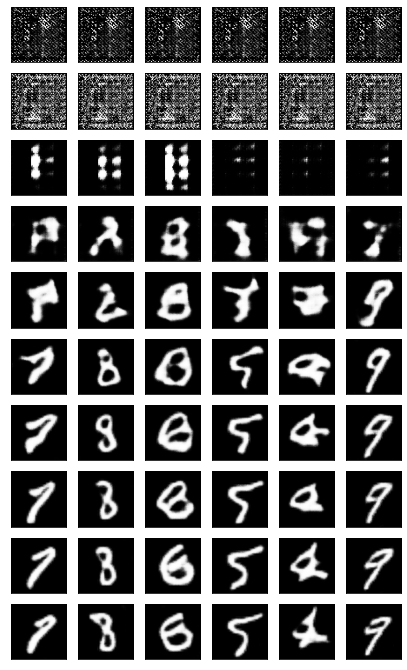

In [147]:
rows = 10 # show every 10 epochs
cols = 6
fig, axes = plt.subplots(figsize=(7,12), nrows=rows, ncols=cols, sharex=True, sharey=True)

for sample, ax_row in zip(samples[::int(len(samples)/rows)], axes):
    for img, ax in zip(sample[::int(len(sample)/cols)], ax_row):
        img = img.detach().cpu()
        ax.imshow(img.reshape((64,64)), cmap='Greys_r')
        ax.xaxis.set_visible(False)
        ax.yaxis.set_visible(False)

## Result sample

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1795: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


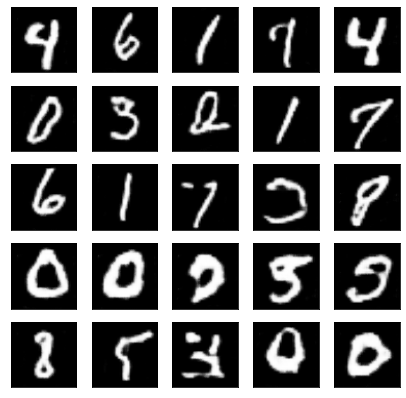

In [166]:
sample_size=25
z = torch.randn((sample_size, z_size, 1, 1)).to(device)

G.eval()
rand_images = G(z)
view_samples(0, [rand_images])